# Abstract: 

### Motivation:
In recent years, many efforts have been made to address areas of low food access, and the detrimental health effects caused by "Food Deserts". 

Under healthcare reforms, providers are more accountable for patients following discharge. High levels of preventable readmissions result in penalties, and reduced federal reimbursement for services.

### Goal:
Explore factors that relate to 30 day readmissions.

### Hypotheses:
* Determine whether encounters that end with a patient leaving against medical advice have higher occurances of 30 day readmissions.
* Determine whether encounters that end with a patient being discharged to skilled nuring facilities have higher occurances of 30 day readmissions.
* Determine if patients admitted by Endocrinologists have lower 30 day readmission rates than those admitted by Internal Medicine physicians.

### Conclusions:


In [ ]:
from scipy.stats.stats import pearsonr
import numpy as np
np.set_printoptions(precision=4, suppress=True)

import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from IPython.core.pylabtools import figsize
import scipy.stats as stats

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/clean_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.fillna(0)
df.rename(columns={'Influenza Death (<65 years of age)':'senior_flu_deaths'}, inplace=True)
df.rename(columns={'Varicella Hospitalizations':'varicella_hospitalizations'}, inplace=True)
df.head()

In [ ]:
bayes_df = df[['n_food_des','cnty_dm_pct_adj','LILATracts_1And10','POP2010' ]]
bayes_df['group'] = bayes_df['LILATracts_1And10'] > np.mean(bayes_df['LILATracts_1And10'])
bayes_df['group'].replace({False: 'low', True: 'high'},inplace=True)

def make_percentage(val):
    return val / 100

bayes_df['cnty_dm_pct_adj'] = bayes_df['cnty_dm_pct_adj'].apply(make_percentage)

bayes_df['n_diabetics']= bayes_df['cnty_dm_pct_adj'] * bayes_df['POP2010']
bayes_df['n_diabetics']=bayes_df['n_diabetics'].astype(int)

a = bayes_df[bayes_df['group']=='high']
b = bayes_df[bayes_df['group']=='low']
bayes_df.head()

In [ ]:
bayes = bayes_df.groupby('group').agg(np.mean)
bayes

# Hypothesis:
## Do counties with a higher prevelance of Food Deserts have a higher prevelance of diabetes?

### Method - AB testing using a Bayesian approach
- A: Counties with a high prevelance of Food Deserts  
    - Includes counties that have a higher prevelance of food deserts than the statewide average.

- B: Counties with average to low prevelance of Food Deserts  
    - Includes counties that have a food desert prevelance that is less than statewide average. 

This analysis focuses on finding the true frequency of diabetic residents based on observed frequencies of seen in counties with a high prevelance of food deserts, and a low-to-average prevelance of food deserts. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of getting heads when flipping a fair coin is 1/2. 

Conversely, the observed frequency is what is actually observed. An example being if we flipped a coin 100 times we may observe 40 heads, and 60 tails. Therefore the observed frequency often differs from the true frequency. However, by applying a bayesian approach we can obtain a better sense of the true frequencies, allowing us to compare the likelihood of a CA county resident being diabetic between the different county groups specified above.

To infer a probable value for the true frequency we can use the observed occurences in our dataset. Here we will compare the age adjusted diabetes prevelance between counties with a high prevelance of food deserts, and those with a low-to-average prevelance of food deserts. But first lets see how age adjusted diabetes rates vary among all CA counties, and each of these groups:

In [ ]:
import pymc as pm
figsize(12, 8)


g=sns.distplot(bayes_df['cnty_dm_pct_adj'],
            kde_kws={"color":"b","lw":4,"label":"KDE Estim - All CA counties","alpha":0.5},
            hist_kws={"color":"b","alpha":0.3,"label":"All CA counties"})

sns.distplot(a['cnty_dm_pct_adj'],
            kde_kws={"color":"g","lw":4,"label":"KDE Estim - high food des","alpha":0.5},
            hist_kws={"color":"g","alpha":0.3,"label":"high food des"})

sns.distplot(b['cnty_dm_pct_adj'],
            kde_kws={"color":"r","lw":4,"label":"KDE Estim - low-avg food des","alpha":0.5},
            hist_kws={"color":"r","alpha":0.3,"label":"low-avg food des"})

# sns.distplot(bayes_df['cnty_dm_pct_adj']) # blue, statewide food desert prev
# sns.distplot(a['cnty_dm_pct_adj']) # green, high food desert prev
# sns.distplot(b['cnty_dm_pct_adj']) # red, avg to low food desert prev

The plot above shows the distribution of county diabetes rates among all CA counties in blue. We can see that majority of counties fall somewhere between 6% and 9%. As stated above, this analysis will focus on comparing diabetes rates in counties with high and low-avg food desert prevelances, both of which fall within this window.

First we assign our probabilities based on the observed diabetes rates amongst the different county groups. Then we assign the number of diabetic residents for each group based off the observations seen in our own dataset. After this we can generate new observations using what was observered in the data. Our generated samples are made using a Bernoulli distribution, meaning all values are 0 or 1.  

0's represent county residents who do not have diabetes. 1's represent county residents who do have diabetes.

All variables including A refer to high food desert counties and all variables including B refer to low to avg food desert counties.

In [ ]:

def gen_obs(prob_col,n_col,frame):
    # Probabilities based on the observed age adjusted diabetes rates amongst high(A) and low-to-avg(B) food_des_counties.
    true_p_A = frame[prob_col].ix[0]
    true_p_B = frame[prob_col].ix[1]
    
    # Sample size based on the observed number of county residents. Unequal sample sizes are acceptable in this type of Bayesian analysis.
    N_A = np.round(frame[n_col].ix[0])
    N_B = np.round(frame[n_col].ix[1])
    
    # Generates new observations based on what was observered in the data using a Bernoulli distribution.
    observations_A = pm.rbernoulli(true_p_A, N_A)
    observations_B = pm.rbernoulli(true_p_B, N_B)
    print "Diabetic county residents - group A (High food desert prevelance): \n", observations_A[:30].astype(int), "..."
    print "Diabetic county residents - group B (Low to average food desert prevelance): \n", observations_B[:30].astype(int), "..."
    return true_p_A, true_p_B, N_A, N_B, observations_A, observations_B
    
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('cnty_dm_pct_adj','POP2010',bayes)

In [ ]:
print observations_A.mean() 
print observations_B.mean()

# Occurrences.mean is equal to n/N.
print "Observed frequency of diabetic residents in High food desert counties: %.4f" % observations_A.mean()
print "Does this observed frequency (%f) equal the true frequency (%f) in original dataset? %s" % (observations_A.mean(), true_p_A, observations_A.mean() == true_p_A)

print
print "Observed frequency of diabetic residents in Low-to-Average food desert counties: %.4f" % observations_B.mean()
print "Does this observed frequency (%f) equal the true frequency (%f) in original dataset? %s" % (observations_B.mean(), true_p_B, observations_B.mean() == true_p_B)


Next we assign our priors to a Uniform distibution. This is a conservative approach, which should be utilized when you do not possess a firm belief about the prior distribution. Then we must define the deterministic delta function. Delta, the return value from this function, represents our estimates of the true frequencies. Finally, we generate observations for our model and use a Markov Chain Monte Carlo model to return samples from the posterior distributions.

In [ ]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B. 
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# Define the deterministic delta function. This is our unknown of interest. 
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets. 
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True) 
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B]) 
mcmc.sample(20000, 1000)

Below assigns our posterior samples according to class and our delta.

In [ ]:
p_A_samples = mcmc.trace("p_A")[:] 
p_B_samples = mcmc.trace("p_B")[:] 
delta_samples = mcmc.trace("delta")[:]

In [ ]:
def plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples):
    figsize(12.5, 10)
    ax = plt.subplot(311)
    plt.xlim(0.05, .08)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_A$", color="#A60628", normed=True)
    plt.vlines(true_p_A, 0, 700, linestyle="--", label="true $p_A$ (unknown)")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A(High:desert)$, $p_B(LowAvg:desert)$, and delta unknowns")
    
    ax = plt.subplot(312)
    plt.xlim(0.05, .08)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_B$", color="#467821", normed=True)
    plt.vlines(true_p_B, 0, 1400, linestyle="--", label="true $p_B$ (unknown)")
    plt.legend(loc="upper right")
    
    ax = plt.subplot(313)
    plt.xlim(-0.001, .006)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(true_p_A - true_p_B, 0, 800, linestyle="--",label="true delta (unknown)")
    plt.vlines(0, 0, 800, color="black", alpha=0.2)
    plt.legend(loc="upper right");

plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples)

Because there is have less high food desert counties, our posterior distribution of pA is fatter, implying we are less certain about the true value of pA than we are of pB.
We can see that the majority of the posterior distribution of delta is above delta=0, implying that high food desert county residents are more likely to be diabetic than residents living in a low to average food desert county. The probability that this inference is incorrect is computed below:

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represents the probability that A residents are 
# less likely to be diabetic than B residents.
print "Probability high food desert counties have LESS diabetic residents than low food desert counties: %.3f" % \
(delta_samples < 0).mean()

print "Probability high food desert counties have More diabetic residents than low food desert counties: %.3f" % \
(delta_samples > 0).mean()

Therefore we can state the probability of a California resident being diabetic is significantly less if they live in a county that has a low to average prevelance of food deserts. Similarly, we can also state those living in CA counties with a high prevelance of food deserts are significantly more likely to be diabetic.

______
Infection Rates: The rate of disease per 100,000 population for the corresponding County, Year, Sex strata using the standard calculation (Count *100,000/Population)

In [ ]:
bayes_df=df[['n_urban','n_rural','County','unemployment_rate','pop2010_in_des','SODA_PRICE10','n_food_des','PC_PHYS_R','FFR07','LILATracts_1And10','POP2010', 'Chlamydia','Tuberculosis','Gonorrhea','HIV','senior_flu_deaths','Measles','Mumps','Pertussis','Rubella','varicella_hospitalizations']]
bayes_df['group'] = bayes_df['LILATracts_1And10'] > np.mean(bayes_df['LILATracts_1And10'])
bayes_df['group'].replace({False: 'low', True: 'high'},inplace=True)


def infx_counts(infx_rate, population):
    count= (infx_rate /100000) * population 
    return np.int64(count)

def append_infx_counts(disease_lst, new_names):
    new_frame = bayes_df.copy(deep=False)
    print new_frame.columns
    for col, new_col in zip(disease_lst,new_names):
        new_frame[new_col] = infx_counts(bayes_df[col],bayes_df['POP2010'])
    return new_frame.drop(disease_lst,axis=1)

preventable_dx = ['Chlamydia','Tuberculosis','Gonorrhea','HIV','senior_flu_deaths','Measles','Mumps','Pertussis','Rubella','varicella_hospitalizations']
new_feat_names = [col+'_count' for col in preventable_dx]

bayes_df = append_infx_counts(preventable_dx, new_feat_names)

bayes_df["std_incidence"] = bayes_df[['Chlamydia_count','Gonorrhea_count','HIV_count']].sum(axis=1)
bayes_df["vaccine_related_incidences"] = bayes_df[['Tuberculosis_count','senior_flu_deaths_count','Measles_count','Mumps_count','Pertussis_count','Rubella_count','varicella_hospitalizations_count']].sum(axis=1)
bayes_df = bayes_df[[col for col in bayes_df.columns if col not in new_feat_names]]
bayes_df.head()

In [ ]:
a=bayes_df[bayes_df['group']=='high']['SODA_PRICE10']
b=bayes_df[bayes_df['group']=='low']['SODA_PRICE10']
y = pd.DataFrame(dict(value=np.r_[a, b], group=np.r_[['high']*len(a), ['low']*len(b)]))

y.hist('value', by='group');


In [ ]:
mu_m = y.value.mean()
mu_s = y.value.std() * 2

with pm.Model() as model:

    group1_mean = pm.Normal('group1_mean', mu_m, sd=mu_s)
    group2_mean = pm.Normal('group2_mean', mu_m, sd=mu_s)

In [ ]:
theta_low = 1
theta_high = 10

with model:

    group1_std = pm.Uniform('group1_std', lower=theta_low, upper=theta_high)
    group2_std = pm.Uniform('group2_std', lower=theta_low, upper=theta_high)

In [ ]:
with model:

    v = pm.Exponential('v_minus_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=False);

In [ ]:
with model:

    lambda1 = group1_std**-2
    lambda2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=v, mu=group1_mean, lam=lambda1, observed=a)
    group2 = pm.StudentT('placebo', nu=v, mu=group2_mean, lam=lambda2, observed=b)

In [ ]:
with model:

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2)))

In [ ]:
with model:
    trace = pm.sample(2000, njobs=2)

In [ ]:
# If you want to create a video and embed that run this cell instead.
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        with NamedTemporaryFile(suffix='.avi') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)



from IPython.display import HTML



def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

animation.Animation._repr_html_ = anim_to_html

# Generate some data
np.random.seed(124)
size = 50
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

# Quickly hacked plotting code
samples = 600
figsize(6, 6)
fig = plt.figure()
i_width = (true_intercept-.7, true_intercept+.7)
s_width = (true_slope-.7, true_slope+.7)
samples_width = (0, samples)
ax1 = fig.add_subplot(221, xlim=i_width, ylim=samples_width)
ax2 = fig.add_subplot(224, xlim=samples_width, ylim=s_width)
ax3 = fig.add_subplot(223, xlim=i_width, ylim=s_width,
                      xlabel='intercept',
                      ylabel='slope')
fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
#path = plt.scatter([], [])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    with model:
        if i == samples * .75:
            for j in range(500): iter_sample.next() 
        trace = iter_sample.next()
    line1.set_data(trace['Intercept'][::-1], range(len(trace['Intercept'])))
    line2.set_data(range(len(trace['x'])), trace['x'][::-1])
    line3.set_data(trace['Intercept'], trace['x'])
    line4.set_data(trace['Intercept'], trace['x'])
    intercept = trace['Intercept'][-1]
    x = trace['x'][-1]
    line5.set_data([intercept, intercept], [x, s_width[1]])
    line6.set_data([intercept, i_width[1]], [x, x])
    return lines

RuntimeError: No MovieWriters available!

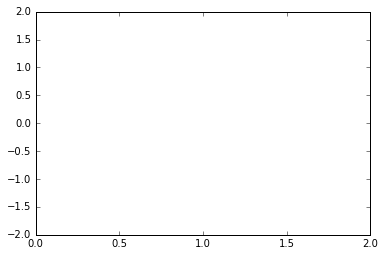

In [3]:
# with pm.Model() as model:
#     pm.glm.glm('y ~ x', data)
#     step = pm.Metropolis()
#     iter_sample = pm.iter_sample(samples+1000, step)

# animation.FuncAnimation(fig, animate, init_func=init,
#                         frames=samples, interval=5, blit=True)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

#HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

In [ ]:


with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    step = pm.Slice()
    iter_sample = pm.iter_sample(samples+1000, step)

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=samples, interval=5, blit=True)

In [ ]:
pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars])


In [ ]:
help(pm.diagnostics)

In [ ]:
glm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

In [ ]:
def prev_dx_ratio(frame, val_feat, pop_val):
    return frame[val_feat] / frame[pop_val]


bayes = bayes_df.groupby('group').agg(np.sum)
bayes['std_rate'] = bayes['std_incidence'] / bayes['POP2010']
bayes

In [ ]:
#sns.jointplot(y='n_food_des', x='std_incidence', data=bayes_df, kind='reg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

def make_percentage(val):
    return val / 100

bayes_df['unemployment_rate'] = bayes_df['unemployment_rate'].apply(make_percentage)

bayes_df['n_unemployed']= bayes_df['unemployment_rate'] * bayes_df['POP2010']
bayes_df['n_unemployed']=bayes_df['n_unemployed'].astype(int)
bayes_df.head()
#df.columns.tolist()

In [ ]:

X = bayes_df[['n_urban','n_rural','n_unemployed','std_incidence']].values
_, num_X = X.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_n_urban = pm.Normal('beta_n_urban', mu=0, sd=100)
    beta_std_incidence = pm.Normal('beta_std_incidence', mu=0, sd=100)
    beta_n_unemployed = pm.Normal('beta_n_unemployed', mu=0, sd=100)
    
    mu = tt.exp(intercept 
                + beta_n_urban*bayes_df.n_urban 
                + beta_std_incidence*bayes_df.std_incidence
                + beta_n_unemployed*bayes_df.n_unemployed)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=bayes_df['n_food_des'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

In [ ]:
_ = pm.traceplot(trace)
#The main takeaway from this is that the effect of changing x 
#depends on the current value of y. Unlike the simple linear regression, 
# a unit change in x does not cause a consistent change in y.

In [ ]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})


In [ ]:
ax = bayes_df['n_unemployed'].plot(
    kind='bar', figsize=(12,3), title='Number of unemployed per county', color=colors[0])
_ = ax.set_xlabel(bayes_df['County'])
_ = ax.set_ylabel('Number of fds')
_ = plt.xticks(rotation=45)

In [ ]:
indiv_traces = {}


n_counties = len(bayes_df['County'])

for p in bayes_df['County']:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = bayes_df[messages['prev_sender']==p]['time_delay_seconds'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

In [ ]:
from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.scatter(x, y, label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2., color='r')
plt.legend(loc=0);

In [ ]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

In [ ]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(x, y, label='data')
glm.plot_posterior_predictive(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

In [ ]:
N=len(bayes_df)
X = df['std_incidence'].values
Y = df['LILATracts_1And10'].values

ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("% County Tracts Food deserts")
plt.ylabel("PCP Civilian ratio")
plt.title("Food deserts Prevelance vs MD ratios")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="lower right");


In [ ]:
import pymc3 as pm
import theano

with pm.Model() as model:
    pm.glm.glm('LILATracts_1And10 ~ PCT_WHITE', df)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, progressbar=True)

In [ ]:
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
#plt.plot(x_out, y_out, 'x', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100, 
                                 label='posterior predictive regression lines')
# plt.plot(x, true_regression_line, 
#          label='true regression line', lw=3., c='y')
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares line")
plt.legend(loc=0);

In [ ]:
sns.distplot(X)

In [ ]:
from pymc.Matplot import plot as mcplot

std = pm.Uniform("std", 0, 100, trace=False)  # this needs to be explained.


@pm.deterministic
def prec(U=std):
    return 1.0 / (U) ** 2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)


@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])

mcmc.sample(100000, 80000)#plot alpha,beta,& prec after sampling 100000 more times, burning 80000 samples, and return every 5th sample (thining).
mcplot(mcmc)

In [ ]:
figsize(12.5, 6)
from scipy.optimize import fmin


def abr_prev(des, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(des)
    ix = des * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(des[ix]) * pred + abs(des[ix])
    sol[~ix] = abs(des[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal \
    + noise


opt_predictions = np.zeros(50)
num_deserts = np.linspace(X.min(), X.max(), 50)
for i, _des in enumerate(num_deserts):
    _possible_outcomes = possible_outcomes(_des)
    tomin = lambda pred: abr_prev(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)

plt.scatter(X, Y, c="k")
plt.xlabel("County Food Deserts Prevelance")
plt.ylabel("ABR prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(num_deserts, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");

In [ ]:
a=bayes[['std_incidence','POP2010']].ix[0].values
b=bayes[['std_incidence','POP2010']].ix[1].values
# data_A = np.r_[[0] * (a[0] - a[1]), [1] * a[1]]
# data_B = np.r_[[0] * (b[0] - b[1]), [1] * b[1]]

def gen_obs(prob_col,n_col,frame):
    # Probabilities based on the observed age adjusted diabetes rates amongst high(A) and low-to-avg(B) food_des_counties.
    true_p_A = frame[prob_col].ix[0]
    true_p_B = frame[prob_col].ix[1]
    
    # Sample size based on the observed number of county residents. Unequal sample sizes are acceptable in this type of Bayesian analysis.
    N_A = np.round(frame[n_col].ix[0])
    N_B = np.round(frame[n_col].ix[1])
    
    # Generates new observations based on what was observered in the data using a Bernoulli distribution.
    observations_A = pm.rbernoulli(true_p_A, N_A)
    observations_B = pm.rbernoulli(true_p_B, N_B)
    print "Diabetic county residents - group A (High food desert prevelance): \n", observations_A[:30].astype(int), "..."
    print "Diabetic county residents - group B (Low to average food desert prevelance): \n", observations_B[:30].astype(int), "..."
    return true_p_A, true_p_B, N_A, N_B, observations_A, observations_B
    
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('std_rate','POP2010',bayes)

In [ ]:
'test'

In [ ]:
true_rates = np.random.beta(51, 51, size=1000)
true_rates
obs = np.random.binomial(100, true_rates)
obs

In [ ]:
clicks_A = 1135
orders_A = 5
clicks_B = 1149
orders_B = 17
data_A = np.r_[[0] * (clicks_A - orders_A), [1] * orders_A]
data_B = np.r_[[0] * (clicks_B - orders_B), [1] * orders_B]
data_A

In [ ]:
import pymc as pm
figsize(12, 4)

def gen_obs(prob_col,n_col,frame):
    true_p_A = frame[prob_col].ix[0]
    true_p_B = frame[prob_col].ix[1]
    N_A = np.round(frame[n_col].ix[0])
    N_B = np.round(frame[n_col].ix[1])
    observations_A = pm.rbernoulli(true_p_A, N_A)
    observations_B = pm.rbernoulli(true_p_B, N_B)
    print "Obs from Site A: ", observations_A[:30].astype(int), "..."
    print "Obs from Site B: ", observations_B[:30].astype(int), "..."
    return true_p_A, true_p_B, N_A, N_B, observations_A, observations_B
    
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('cnty_dm_pct','POP2010',bayes)